In [9]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar


--2025-04-23 18:02:08--  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 6932971618 (6.5G) [application/x-rar-compressed]
Saving to: ‘UCF101.rar’

UCF101.rar          100%[===================>]   6.46G  69.6MB/s    in 2m 28s  

2025-04-23 18:04:36 (44.7 MB/s) - ‘UCF101.rar’ saved [6932971618/6932971618]



In [10]:
!unrar x UCF101.rar /content/


Streaming output truncated to the last 5000 lines.
Extracting  /content/UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c05.avi      62%  OK 
Extracting  /content/UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c06.avi      62%  OK 
Extracting  /content/UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi      62%  OK 
Extracting  /content/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi      62%  OK 
Extracting  /content/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi      62%  OK 
Extracting  /content/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi      62%  OK 
Extracting  /content/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi      62%  OK 
Extracting  /content/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi      62%  OK 
Extracting  /content/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi      62%  OK 
Extracting  /content/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi      62%  OK 
Extractin

In [11]:
import os
import shutil
import random

# Set paths
SOURCE_DIR = '/content/UCF-101'
DEST_DIR = '/content/UCF101_subset'
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

# Create destination directory
os.makedirs(DEST_DIR, exist_ok=True)

for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)
    os.makedirs(dest_class_path, exist_ok=True)

    selected_videos = random.sample(os.listdir(class_path), VIDEOS_PER_CLASS)
    for video in selected_videos:
        shutil.copy(os.path.join(class_path, video), dest_class_path)



In [12]:
import cv2
import os

VIDEO_DIR = '/content/UCF101_subset'
FRAME_DIR = '/content/UCF101_frames'
FRAME_EVERY = 5
RESIZE_SHAPE = (112, 112)

os.makedirs(FRAME_DIR, exist_ok=True)

for class_name in os.listdir(VIDEO_DIR):
    class_path = os.path.join(VIDEO_DIR, class_name)
    for video_name in os.listdir(class_path):
        video_path = os.path.join(class_path, video_name)
        video_basename = os.path.splitext(video_name)[0]

        # Create destination folder
        frame_output_dir = os.path.join(FRAME_DIR, class_name, video_basename)
        os.makedirs(frame_output_dir, exist_ok=True)

        # Open video
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        saved_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % FRAME_EVERY == 0:
                resized = cv2.resize(frame, RESIZE_SHAPE)
                frame_filename = os.path.join(frame_output_dir, f'frame_{saved_count:04d}.jpg')
                cv2.imwrite(frame_filename, resized)
                saved_count += 1
            frame_count += 1
        cap.release()


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img

FRAME_DIR = '/content/UCF101_frames'
SEQUENCE_LENGTH = 16
IMG_SIZE = (112, 112)

X = []
y = []

classes = sorted(os.listdir(FRAME_DIR))
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(classes)

label_map = dict(zip(classes, encoded_labels))

for class_name in classes:
    class_path = os.path.join(FRAME_DIR, class_name)
    for video_folder in os.listdir(class_path):
        frame_files = sorted(glob.glob(os.path.join(class_path, video_folder, '*.jpg')))
        if len(frame_files) < SEQUENCE_LENGTH:
            continue  # skip if not enough frames

        # Select first 16 frames only
        selected_frames = frame_files[:SEQUENCE_LENGTH]
        frames = [img_to_array(load_img(frame, target_size=IMG_SIZE)) for frame in selected_frames]
        X.append(np.array(frames))
        y.append(label_map[class_name])

X = np.array(X)
y = to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (38, 16, 112, 112, 3)
y_train shape: (38, 5)


In [15]:
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Build the CNN + LSTM model
model = Sequential()

# TimeDistributed wrapper applies Conv2D to each frame in the sequence
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(SEQUENCE_LENGTH, IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))

# LSTM layer for temporal sequence processing
model.add(LSTM(64, return_sequences=False))

# Fully connected layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(len(classes), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 110, 110,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 55, 55, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 53, 53, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 26, 26, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 24, 24,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 12, 12,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 18432)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     4,735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,837,445 (18.45 MB)

 Trainable params: 4,837,445 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test))


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.1746 - loss: 1.7971 - val_accuracy: 0.1000 - val_loss: 1.6221
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.1606 - loss: 1.8207 - val_accuracy: 0.1000 - val_loss: 1.8749
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.2886 - loss: 1.6187 - val_accuracy: 0.1000 - val_loss: 1.8342
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.2173 - loss: 1.8755 - val_accuracy: 0.1000 - val_loss: 1.7719
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.2364 - loss: 1.6528 - val_accuracy: 0.1000 - val_loss: 1.7683
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.1111 - loss: 1.6404 - val_accuracy: 0.1000 - val_loss: 1.7384
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.2120 - loss: 1.5733 - val_accuracy: 0.1000 - val_loss: 1.7323
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.1897 - loss: 1.6832 - val_accuracy: 0.1000 - val_loss:

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict using the model
y_pred = model.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1000 - loss: 1.7890
Test Accuracy: 10.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print(conf_matrix)


               precision    recall  f1-score   support

   Basketball       0.00      0.00      0.00         1
       Biking       0.00      0.00      0.00         1
     JumpRope       0.00      0.00      0.00         5
PlayingGuitar       0.10      1.00      0.18         1
       Typing       0.00      0.00      0.00         2

     accuracy                           0.10        10
    macro avg       0.02      0.20      0.04        10
 weighted avg       0.01      0.10      0.02        10

[[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 5 0]
 [0 0 0 1 0]
 [0 0 0 2 0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


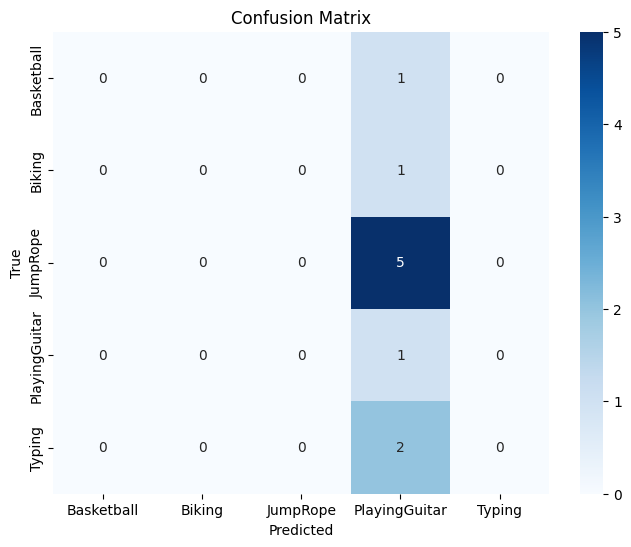

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
